## Notebook 5: Linear systems

In [ ]:
using LaTeXStrings
using LinearAlgebra
using Plots
using Polynomials

### <font color='green'>Conditioning</font>

### <font color='orange'>[Exercise 1]</font> Link between conditioning and relative error

Consider the linear system
$$
    \mathsf A(α) \mathbf x :=
    \begin{pmatrix}
        1 & 1 \\
        1 & 1 - α
    \end{pmatrix}
    \begin{pmatrix}
        x_1 \\
        x_2
    \end{pmatrix} =
    \begin{pmatrix}
        π \\
        π - πα
    \end{pmatrix} =: \mathbf b(α).
$$
For $α$ in the range $[10^{-15}, 10^{-2}]$,
plot on the same graph, using logarithmic scales for both axes,

- The function which to $α$ associate $\kappa_2\bigl(\mathsf A(α)\bigr) \times ε$,
  where $\kappa_2\bigl(\mathsf A(α)\bigr)$ is the condition number of the matrix $A(α)$ for the Euclidean norm,
  and $ε$ is the machine epsilon for the `Float64` format.

- The relative error, in Euclidean norm, obtained when solving the linear system with the backslash `\` operator,
  in the case where both $A(α)$ and $b(α)$ are stored in the `Float64` format.

In [ ]:
Af(α) = [1. 1.; 1. (1-α)]
bf(α) = [π; π - π*α]

# Exact solution
x_exact = [0.; π]

# Range of α
αs = 10. .^ (-15:.1:-2)

### BEGIN SOLUTION
rel_err(α) = norm(Af(α)\bf(α) - x_exact)/norm(x_exact)
plot(αs, rel_err.(αs), label=L"$ℓ^2$ error")
# rel_err_A(α) = norm(Af(α)\bf(BigFloat(α)) - x_exact)/norm(x_exact)
# rel_err_b(α) = norm(Af(BigFloat(α))\bf(α) - x_exact)/norm(x_exact)
# plot!(αs, rel_err_A.(αs), label=L"$ℓ^2$ error from A")
# plot!(αs, rel_err_b.(αs), label=L"$ℓ^2$ error from b")
plot!(αs, cond.(Af.(αs)) * eps(), label=L"κ_2(A) \times ε")
plot!(xscale=:log10, yscale=:log10, xlabel=L"α")
### END SOLUTION

### <font color='green'>Direct methods</font>

### <font color='orange'>[Exercise 2]</font> LU decomposition without Gaussian elimination

The objective of this exercise is to propose an algorithm to perform the LU decomposition of a real matrix $\mathsf{A}\in\mathbb{R}^{n×n}$,
**not by Gaussian elimination** but by identifying the entries of $\mathsf A$ with those of $\mathsf L \mathsf U$.
The aim is to find a unit lower triangular matrix $\mathsf L$
and an upper triangular matrix $\mathsf U$ such that:
<a id="LU"></a>
$$
\tag{LU}
\mathsf{A}=\mathsf{L}\mathsf{U}
$$

1. Write a function `my_lu(A)` that takes a matrix `A` as an argument and returns the matrices `L` and `U`.
   To compute these matrices, rely on the successive identification of the elements on both sides of <a href="#LU">(LU)</a>,
   row by row from top to bottom, and from left to right within each row.

   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   When following the suggested order,
   comparing the element $(i, j)$ provides an equation for $\ell_{ij}$ if $j < i$,
   and an equation for $u_{ij}$ if $j \geq i$.
   Note that it is possible to traverse the elements in other orders.
   </details>

In [ ]:
function my_lu(A)
    ### BEGIN SOLUTION
    n = size(A, 1)
    L, U = zeros(n, n), zeros(n, n)
    for i in 1:n
        for j in 1:i-1
            L[i, j] = (A[i, j] - L[i, 1:j-1]'U[1:j-1, j]) / U[j, j]
        end
        for j in i:n
            U[i, j] = A[i, j] - L[i, 1:i-1]'U[1:i-1, j]
        end    
    end
    ### END SOLUTION
    return L, U
end;

In [ ]:
ref_lu(A) = LinearAlgebra.lu(A, NoPivot())
@assert my_lu(diagm([1; 2; 3])) == (diagm([1; 1; 1]), diagm([1; 2; 3]))
@assert my_lu([2 -1 0; -1 2 -1; 0 -1 2])[1] ≈ [1 0 0; -1/2 1 0; 0 -2/3 1]
@assert my_lu([2 -1 0; -1 2 -1; 0 -1 2])[2] ≈ [2 -1 0; 0 3/2 -1; 0 0 4/3]
@assert (C = [1 2 3 4; 4 3 2 1; 1 2 1 2; 1 5 4 1]; my_lu(C)[1] ≈ ref_lu(C).L)
@assert (C = [1 2 3 4; 4 3 2 1; 1 2 1 2; 1 5 4 1]; my_lu(C)[2] ≈ ref_lu(C).U)
@assert (C = randn(100, 100); my_lu(C)[1] ≈ ref_lu(C).L)
@assert (C = randn(100, 100); my_lu(C)[2] ≈ ref_lu(C).U)

2. We now assume that the real positive definite matrix `A` has a bandwidth `b` assumed to be much smaller than `n`.
   Rewrite the LU decomposition function by taking advantage of the bandwidth.

   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   Recall that the bandwidth is the smallest natural number $b$ such that $a_{ij} = 0$ for all $i,j \in \{1, \dots, n\}^2$ such that $|i-j| > b$.
   </details>

In [ ]:
function my_banded_lu(A, b)
    ### BEGIN SOLUTION
    n = size(A, 1)
    L, U = zeros(n, n), zeros(n, n)
    for i in 1:n, j in max(1, i-b):i
        U[j, i] = A[j, i] - L[j, max(j-b, 1):j-1]'U[max(j-b, 1):j-1, i]
        L[i, j] = (A[i, j] - L[i, max(j-b, 1):j-1]'U[max(j-b, 1):j-1, j]) / U[j, j]
    end
    ### END SOLUTION
    return L, U
end;

In [ ]:
@assert begin C = randn(100, 100); my_banded_lu(C, 99)[1] ≈ ref_lu(C).L end
@assert begin C = randn(100, 100); my_banded_lu(C, 99)[2] ≈ ref_lu(C).U end

### BEGIN HIDDEN TESTS
_generate_banded(n, b) = [abs(i - j) ≤ b ? randn() : 0. for i in 1:n, j in 1:n]
@assert (C = _generate_banded(10, 2); my_banded_lu(C, 2)[1] ≈ ref_lu(C).L)
@assert (C = _generate_banded(10, 2); my_banded_lu(C, 2)[2] ≈ ref_lu(C).U)
@assert (C = _generate_banded(10, 3); my_banded_lu(C, 3)[1] ≈ ref_lu(C).L)
@assert (C = _generate_banded(10, 3); my_banded_lu(C, 3)[2] ≈ ref_lu(C).U)
@assert (C = _generate_banded(1000, 1); my_banded_lu(C, 1)[1] ≈ ref_lu(C).L)
@assert (C = _generate_banded(1000, 1); my_banded_lu(C, 1)[2] ≈ ref_lu(C).U)
### END HIDDEN TESTS

3. Create a function `generate_banded(n, b)` to generate a random square matrix of size `n` with a given bandwidth `b`.

In [ ]:
function generate_banded(n, b)
    ### BEGIN SOLUTION
    A = zeros(n, n)
    for i in 1:n
        for j in max(1, i-b):min(n, i+b)
            A[i, j] = randn()
        end
    end
    return A
    ### END SOLUTION
end;

In [ ]:
@assert generate_banded(10, 2)[1, 5] == 0
@assert generate_banded(10, 2)[2, 5] == 0
@assert generate_banded(10, 2)[3, 5] != 0
@assert generate_banded(10, 2)[4, 5] != 0
@assert generate_banded(10, 2)[5, 5] != 0
@assert generate_banded(10, 2)[6, 5] != 0
@assert generate_banded(10, 2)[7, 5] != 0
@assert generate_banded(10, 2)[8, 5] == 0
@assert generate_banded(10, 2)[9, 5] == 0

4. Using `generate_banded`, test your implementation of `my_banded_lu`
   for `n = 100` and values of `b` equal to 2, 3, and 10.
   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   You can use the `lu` function from the `LinearAlgebra` library,
   with the argument `NoPivot()`, corresponding to the `ref_lu` function defined above,
   as a reference function.
   You can also use the `@assert` macro for your tests.
   </details>

In [ ]:
### BEGIN SOLUTION
# See hidden tests above
### END SOLUTION

### <font color='green'>Iterative methods</font>

### <font color='orange'>[Exercise 3]</font> Richardson's iteration

Consider the following linear system:
$$
    \mathsf A \mathbf x :=
    \begin{pmatrix}
        3 & 1 \\ 1 & 3
    \end{pmatrix}
    \begin{pmatrix}
        x_1 \\
        x_2
    \end{pmatrix}
    =
    \begin{pmatrix}
        11 \\
        9
    \end{pmatrix} =: \mathbf b.
$$

 1. Illustrate using the `Plots.contourf` function the contour lines of the function
 $$
     f(\mathbf x) = \frac{1}{2} \mathbf x^T \mathsf A \mathbf x - \mathbf b^T \mathbf x.
 $$

In [ ]:
A = [3. 1.; 1. 3.]
b = [11.; 9.]
sol = A\b

### BEGIN SOLUTION
ℓ, nplot = 4, 100
xplot = sol[1] .+ LinRange(-ℓ, ℓ, nplot)
yplot = sol[2] .+ LinRange(-ℓ, ℓ, nplot)

plot(aspect_ratio=:equal, bg=:transparent)
plot!(xlims=xplot[[1,end]], ylims=yplot[[1,end]], legend=:none)
contourf!(xplot, yplot, (x₁, x₂) -> [x₁; x₂]'A*[x₁; x₂]/2 - b'*[x₁; x₂], c=:viridis)
### END SOLUTION

 2. Implement the Richardson iteration with $\omega = 0.1$ to solve the system.
    Your function should return a list containing all iterations.
    Initialize the algorithm at $\mathbf x = 0$ and,
    as a stopping criterion, use
    $$
    \lVert \mathsf A \mathbf x - \mathbf b \lVert \leq \varepsilon \lVert \mathbf b \lVert, \qquad \varepsilon = 10^{-50}
    $$
    <details>
        <summary>
            <em><font color='gray'>Hint (click to display)</font></em>
        </summary>

    To add an element to the end of a list,
    use the `push!` function:

    ```julia
    push!(xs, x)  # Adds x at the end of xs
    ```
    </details>

In [ ]:
function richardson(ω)
    ε = 1e-50
    x = zeros(BigFloat, 2)
    xs = [x]
    # BEGIN SOLUTION
    while norm(A*x - b)/norm(b) ≥ ε
        x -= ω*(A*x - b)
        push!(xs, x)
    end
    # END SOLUTION
    return xs
end

ω = .1
xs = richardson(ω)
scatter!(eachrow(hcat(xs...))...)
plot!(eachrow(hcat(xs...))...)

 3. Plot the norm of the residual $\lVert r_k \rVert := \lVert \mathsf A \mathbf x^{(k)} - \mathbf b \rVert$ as a function of $k$,
    using a linear scale for the x-axis and a logarithmic scale for the y-axis,
    by passing the argument `yscale=:log` to the `Plots.plot` function.

In [ ]:
### BEGIN SOLUTION
errors = [norm(A*x - b) for x in xs]
plot(0:length(xs) - 1, errors, label="Error")
plot!(yscale=:log, xlabel=L"k")
### END SOLUTION

 4. Using `Polynomials.fit`, compute an approximation of the form
    $$
    \log(r_k) \approx α + βk \qquad \Leftrightarrow \qquad e_k \approx \exp(α) \times \exp(β)^k.
    $$
    Compare the value of $\exp(β)$ to the spectral radius $\rho(\mathsf A - \omega \mathsf I)$.

In [ ]:
# Define b and ρ below
### BEGIN SOLUTION
p = fit(1:length(errors), log.(errors), 1)
β = p[1]  # p[1] == p.coeffs[2]
λs = eigvals(A)
ρ = maximum(abs.(1 .- ω*λs))
### END SOLUTION

exp(β), ρ

5. Calculate the optimal parameter $\omega$ and re-plot the decay of the residual norm in this case.

In [ ]:
### BEGIN SOLUTION
ω = 2 / (minimum(λs) + maximum(λs))
xs = richardson(ω)
errors = [norm(A*x - b) for x in xs]
plot(yscale=:log, xlabel=L"k", bg=:transparent)
plot!(0:length(xs) - 1, errors, label="Error")
### END SOLUTION

### <font color='orange'>[Exercise 4]</font> Basic iterative method for the Euler-Bernoulli beam

The objective of this exercise is to solve the Euler-Bernoulli beam equation in one dimension,
with homogeneous Dirichlet boundary conditions:
$$
u''''(x) = 1, \qquad u(0) = u'(0) = u'(1) = u(1) = 0.
$$
This equation models the deflection of a beam clamped at both ends,
under a uniform load.
A discretization of this equation on a uniform grid using the finite difference method leads to the following linear system:
$$
\begin{pmatrix}
    6  & -4 & 1 \\
    -4 & 6  & -4 & 1 \\
     1 & -4 & 6      & -4 & 1 \\
     & 1 & -4 & 6      & -4 & 1 \\
     &  &  \ddots  & \ddots & \ddots & \ddots & \ddots  \\
     & &    &   1    & -4    & 6      & -4 & 1 \\
     & & &    &   1    & -4    & 6      & -4 \\
     & & &    &        &  1  & -4      & 6 \\
\end{pmatrix}
\begin{pmatrix}
    u_2 \\
    u_3 \\
    u_4 \\
    u_5 \\
    \vdots \\
    u_{n-4} \\
    u_{n-3} \\
    u_{n-2}
\end{pmatrix}
=
h^4
\begin{pmatrix}
    1 \\
    1 \\
    1 \\
    1 \\
    \vdots \\
    1 \\
    1 \\
    1
\end{pmatrix},
\quad
h := \frac{1}{n},
\quad
x_i := ih.
$$
where $h$ is the spacing between the discretization points, and $(u_2, u_3, \cdots, u_{n-3}, u_{n-2})$ are the values of the unknown function $u$ at the points $(x_2, x_3, \cdots, x_{n-3}, x_{n-2})$.

1. Write a function `build_matrix(n)`, which returns the matrix of the linear system.

   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   The function `LinearAlgebra.diagm` is useful to construct the matrix.
   For example, the command
   ```julia
   diagm(0 => [1, 2, 3], -1 => [5, 5])  # = [1 0 0; 5 2 0; 0 5 3]
   ```
   returns a 3x3 matrix with `[1, 2, 3]` on the main diagonal,
   and `[5, 5]` on the first subdiagonal.
   </details>

In [ ]:
function build_matrix(n)
    ### BEGIN SOLUTION
    m = n - 3
    A = diagm(-2 => fill(1, m-2), -1 => fill(-4, m-1), 0 => fill(3, m))
    return A + A'
    ### END SOLUTION
end

In [ ]:
@assert size(build_matrix(20)) == (17, 17)
@assert build_matrix(20)[5, 3] ≈ 1
@assert build_matrix(20)[5, 4] ≈ -4
@assert build_matrix(20)[5, 5] ≈ 6
@assert build_matrix(20)[5, 6] ≈ -4
@assert build_matrix(20)[5, 7] ≈ 1
@assert build_matrix(20)[5, 8] ≈ 0

2. Write a function `build_rhs(n)`, which returns the right-hand side of the linear system.

In [ ]:
function build_rhs(n)
    ### BEGIN SOLUTION
    m = n - 3
    return fill(1/n^4, m)
    ### END SOLUTION
end

In [ ]:
@assert length(build_rhs(20)) == 17
@assert build_rhs(20)[end] == 1 / 20^4
@assert build_rhs(20)[1] == 1 / 20^4

3. Write a function `forward_substitution(L, y)`
   that solves the linear system $\mathsf L \mathbf x = \mathbf y$,
   in the case where `L` is a lower-triangular matrix,
   by using forward substitution.

In [ ]:
function forward_substitution(L, y)
    ### BEGIN SOLUTION
    z = copy(y)
    n = length(y)
    for i in 1:n
        for j in 1:i-1
            z[i] -= L[i, j] * z[j]
        end
        z[i] /= L[i, i]
    end
    return z
    ### END SOLUTION
end

In [ ]:
@assert begin n = 10; L = [1 0; 2 1]; forward_substitution(L, [1; 0]) ≈ [1; -2] end
@assert begin n = 10; L = LowerTriangular(ones(n, n)); y = fill(2, n); forward_substitution(L, L*y) ≈ y end
@assert begin n = 10; L = LowerTriangular(randn(n, n)); y = randn(n); forward_substitution(L, L*y) ≈ y end
@assert begin n = 20; L = LowerTriangular(2ones(n, n)); y = rand(n); forward_substitution(L, L*y) ≈ y end

4. The successive over-relaxation method is a splitting method for solving linear systems of the form $\mathsf A \mathbf x = \mathbf b$.
   It is based on the iteration
   $$
   \mathsf M \mathbf x_{k+1} = \mathsf N \mathbf x_{k} + \mathbf{b}, \qquad \text{where} \quad \mathsf M = \frac{\mathsf D}{\omega} + \mathsf L \quad \text{and} \quad \mathsf N = \mathsf M - \mathsf A.
   \tag{SOR}
   $$
   <a id="SOR"></a>
   Here $\omega \in (0, 2)$ is a parameter,
   $\mathsf D$ is diagonal matrix containing the diagonal of $\mathsf A$,
   and $\mathsf L$ is a strictly lower triangular matrix containing the strict lower triangular part of $\mathsf A$,
   not including the diagonal.
   Write a function `sor(A, b, ω)` that
   implements this iteration, without using Julia's `\` and `inv` functions.
   Initialize the iteration at $\mathbf x_0 = \mathbf 0$,
   and use as stopping criterion that
   $$
   \lVert \mathsf A \mathbf x - \mathbf b \rVert
   \leq \varepsilon \lVert \mathbf b \rVert,
   \qquad \varepsilon := 10^{-10}.
   $$
   If after `maxiter` iterations,
   a solution that satisfies this stopping criterion has not been found,
   return `nothing`.

   <details>
       <summary>
           <em><font color='gray'>Hint (click to display)</font></em>
       </summary>

   - The functions `Diagonal` and `LowerTriangular`,
     both from the `LinearAlgebra` library,
     are useful to construct the matrices $\mathsf D$ and $\mathsf L$:
     ```julia
     D = Diagonal(A)  # Extracts the diagonal from A
     X = LowerTriangular(A)  # Extracts lower triangular part, with diag
     ```
   - Since the matrix in the linear system <a href="#NR">(SOR)</a> is lower triangular,
     use the function `forward_substitution` you wrote above to solve this system at each iteration.
   </details>

In [ ]:
function sor(A, b; ω = 1, ε = 1e-10, maxiter = 10^5)
    ### BEGIN SOLUTION
    n = length(b)
    x = zeros(n)
    D = Diagonal(A)
    L = LowerTriangular(A) - D
    M = L + D/ω
    for i in 1:maxiter
        if norm(A*x - b) ≤ ε * norm(b)
            return x
        end
        x = forward_substitution(M, (M-A)*x + b)
    end
    print("Did not converge!")
    return nothing
    ### END SOLUTION
end

In [ ]:
# Test code
n = 20
X = qr(randn(n, n)).Q
A = X*Diagonal(rand(n) .+ 5)*X'
b = randn(n)
@assert begin ε = 1e-10; sol = sor(A, b; ω = 1.5, ε = ε); norm(A*sol - b) ≤ ε*norm(b) end
@assert begin ε = 1e-10; sol = sor(A, b; ω = 1.5, ε = ε); norm(A*sol - b) ≥ 1e-15*norm(b) end
@assert begin ε = 1e-12; sol = sor(A, b; ω = 1.5, ε = ε); norm(A*sol - b) ≤ ε*norm(b) end
@assert begin ε = 1e-12; sor(A, b; ω = 2, ε = ε) == nothing end
@assert begin ε = 1e-12; sor(A, b; ω = 1, ε = ε) ≈ A\b end

**Remark**. Here we used a function with both non-keyword (before `;`) and keyword (after `;`) arguments,
as well as default values for the keyword arguments.
When default values are present, the arguments become optional.
The following example should help you understand how arguments are handled in Julia.

In [ ]:
my_test(a , b = 2; c = 3, d = 4) = "Arguments: $a $b $c $d"
@show my_test(5)
@show my_test(5, 8)
@show my_test(5, 8; c = 9)
@show my_test(5, 8; d = 9)
@show my_test(5; d = 9);

# my_test(5, 8, 9)  # -> Error because there are only two non-keyword arguments
# my_test(5, 8; 9)  # -> Error because there should only be keyword arguments after ';'

5. Use the relaxation method implemented in the previous item
   with parameters $\omega = 1.9$ and $\varepsilon = 10^{-8}$ to solve the linear system of this exercise with $n = 50$.
   Compare on a graph the solution you obatined with the exact solution,
   which is given by
   $$ u(x) = \frac{1}{24} x^2(x - 1)^2. $$

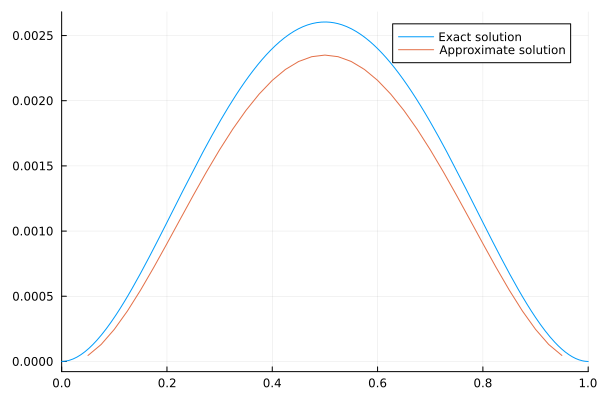

In [49]:
u(x) = 1/24 * x^2 * (x - 1)^2

### BEGIN SOLUTION
n, ε = 40, 1e-8
A = build_matrix(n)
b = build_rhs(n)
sol = sor(A, b; ω = 1.9, ε = ε)
x = LinRange(0, 1, n + 1)
plot(u, xlims = (0, 1), label="Exact solution")
plot!(x[3:end-2], A\b, xlims = (0, 1), label="Approximate solution")
### END SOLUTION